# Problem 3 - Mean-Variance Frontier and Portfolio Choice

In [413]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

## a)

In [414]:
data = pd.read_csv('PS1 - Data.csv', index_col = 0)
# Discrete Monthly Returns
for column in data.columns:
    data[column] = data[column].pct_change(periods = 1)
print(data.head(n = 5))

            DEUTSCHE_BANK   ALLIANZ      BASF   SIEMENS       BMW     BAYER  \
1996-07-23            NaN       NaN       NaN       NaN       NaN       NaN   
1996-08-23       0.005421  0.035851  0.085921  0.023022  0.018961  0.062685   
1996-09-23      -0.029687 -0.004419  0.082109  0.003933  0.011622  0.038204   
1996-10-23      -0.004588  0.029361  0.029044  0.011900  0.033911  0.042568   
1996-11-23      -0.003359  0.007230  0.085472 -0.104982  0.039467  0.019031   

                E_ON       RWE    HENKEL       SAP  
1996-07-23       NaN       NaN       NaN       NaN  
1996-08-23  0.027119  0.030107  0.015875  0.106914  
1996-09-23  0.015450  0.031968  0.015520  0.063693  
1996-10-23  0.057710  0.146010  0.027635 -0.176907  
1996-11-23  0.035129  0.027803  0.126821 -0.048978  


In [415]:
# Risk Free Interest Rate
rf_return = 0.08/100
# Annualized Risk Free Interest Rate
rf_return = rf_return * 12

In [416]:
# Monthly Expected Returns
returns = data.mean(axis = 0, skipna = True)
# Annualized Expected Returns
returns = returns * 12
print(returns)

DEUTSCHE_BANK    0.069372
ALLIANZ          0.117179
BASF             0.154088
SIEMENS          0.155251
BMW              0.152583
BAYER            0.104574
E_ON             0.075657
RWE              0.091904
HENKEL           0.122083
SAP              0.177752
dtype: float64


In [417]:
# Monthly Standard Deviation
std = data.std(axis = 0, skipna = True)
# Annualized Standard Deviation
std = np.sqrt(12) * std
print(std)

DEUTSCHE_BANK    0.426518
ALLIANZ          0.350028
BASF             0.283615
SIEMENS          0.339217
BMW              0.323900
BAYER            0.296909
E_ON             0.270180
RWE              0.310031
HENKEL           0.222917
SAP              0.351835
dtype: float64


In [418]:
std_returns = pd.concat([returns, std], axis = 1)
std_returns.rename(columns = {0: 'return', 1: 'std'}, inplace = True)
print(std_returns)

                 return       std
DEUTSCHE_BANK  0.069372  0.426518
ALLIANZ        0.117179  0.350028
BASF           0.154088  0.283615
SIEMENS        0.155251  0.339217
BMW            0.152583  0.323900
BAYER          0.104574  0.296909
E_ON           0.075657  0.270180
RWE            0.091904  0.310031
HENKEL         0.122083  0.222917
SAP            0.177752  0.351835


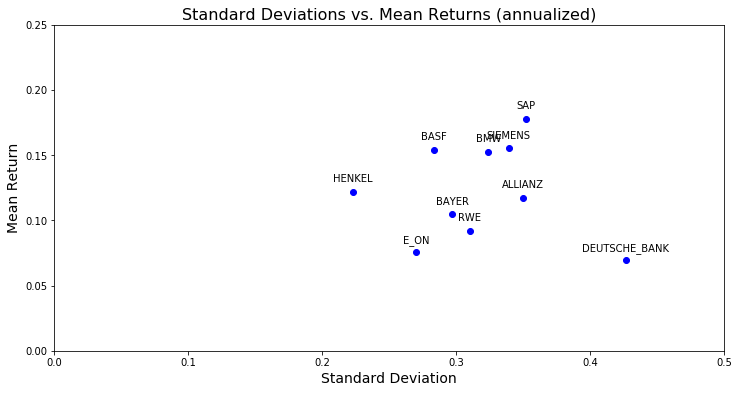

In [419]:
plt.figure(figsize = (12,6))
plt.plot(std_returns['std'], std_returns['return'], linestyle = "None", marker = 'o', color = 'blue')
for i in range(0, len(std_returns)):
    index = std_returns.index.to_numpy()
    label = index[i]
    plt.annotate(label, (std_returns.iloc[i,1], std_returns.iloc[i,0]), textcoords = "offset points", xytext = (0, 10), ha = 'center')
plt.title('Standard Deviations vs. Mean Returns (annualized)', size = 16)
plt.xlabel('Standard Deviation', size = 14)
plt.ylabel('Mean Return', size = 14)
plt.xlim(0, 0.5)
plt.ylim(0, 0.25)
plt.show()

## b)

In [420]:
portfolio_returns = [] 
portfolio_stds = []
portfolio_weights = [] 

num_assets = len(data.columns)
num_portfolios = 1000

cov_matrix = data.cov()
cov_matrix = cov_matrix * 12

for z in range(0, int(num_portfolios/(num_assets**2))):
    for i in range(0, num_assets):
        weights = np.random.random(num_assets-i)
        weights = np.append(weights, np.zeros(i))
        weights = weights/np.sum(weights)
        for j in range(0, num_assets):
            # Portfolio Weights
            weights = deque(weights)
            weights.rotate(i)
            weights = np.array(weights)
            portfolio_weights.append(weights)
            # Portfolio Returns
            returns = np.dot(weights, std_returns['return'])
            portfolio_returns.append(returns)
            # Portfolio Volatlity (Stds)
            var = np.dot(weights.T, np.dot(cov_matrix, weights))
            std = np.sqrt(var)
            portfolio_stds.append(std)

portfolio_std_returns = pd.DataFrame({'return': portfolio_returns, 'std': portfolio_stds})
print(portfolio_std_returns)

       return       std
0    0.114951  0.229914
1    0.114951  0.229914
2    0.114951  0.229914
3    0.114951  0.229914
4    0.114951  0.229914
..        ...       ...
995  0.152583  0.323900
996  0.155251  0.339217
997  0.154088  0.283615
998  0.117179  0.350028
999  0.069372  0.426518

[1000 rows x 2 columns]


In [421]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.dot(weights, std_returns['return'])
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    return np.sum(weights)-1

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

In [422]:
eff_portfolios = pd.DataFrame()

frontier_y = np.linspace(0, 0.4, 10000)
frontier_x = []

init_guess = [1/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10, 1/10]

for possible_return in frontier_y:
    cons = ({'type': 'eq', 'fun': check_sum}, {'type': 'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = minimize(minimize_volatility, init_guess, method = 'SLSQP', constraints = cons)
    for i in range(0, num_assets):
        if i == 0:
            eff_portfolios.loc[len(eff_portfolios), i] = result['jac'][i]
        else:
            eff_portfolios.loc[len(eff_portfolios) - 1, i] = result['jac'][i]
    eff_portfolios.loc[len(eff_portfolios) - 1, num_assets] = result['fun']
    eff_portfolios.loc[len(eff_portfolios) - 1, num_assets + 1] = possible_return
    eff_portfolios.loc[len(eff_portfolios) - 1, num_assets + 2] = possible_return/result['fun']
    frontier_x.append(result['fun'])

eff_portfolios.rename(columns = {0: 'w_DEUTSCHE_BANK', 1: 'w_ALLIANZ', 2: 'w_BASF', 3: 'w_SIEMENS', 4: 'w_BMW', 5: 'w_BAYER', 6: 'w_E_ON', 7: 'w_RWE', 8: 'w_HENKEL', 9: 'w_SAP', 10: 'std', 11: 'return', 12: 'sharpe_ratio'}, inplace = True)
print(eff_portfolios.head(n = 10))

   w_DEUTSCHE_BANK  w_ALLIANZ    w_BASF  w_SIEMENS     w_BMW   w_BAYER  \
0         0.210186   0.125263  0.058958   0.057101  0.061581  0.147550   
1         0.210202   0.125290  0.058992   0.057137  0.061617  0.147574   
2         0.210217   0.125316  0.059025   0.057172  0.061653  0.147597   
3         0.210232   0.125343  0.059058   0.057207  0.061689  0.147621   
4         0.210247   0.125369  0.059091   0.057242  0.061725  0.147644   
5         0.210262   0.125396  0.059125   0.057278  0.061761  0.147668   
6         0.210277   0.125422  0.059158   0.057313  0.061797  0.147692   
7         0.210292   0.125448  0.059191   0.057348  0.061832  0.147715   
8         0.210308   0.125475  0.059225   0.057383  0.061868  0.147739   
9         0.210323   0.125501  0.059258   0.057419  0.061904  0.147762   

     w_E_ON     w_RWE  w_HENKEL     w_SAP       std   return  sharpe_ratio  
0  0.198834  0.170354  0.116253  0.017091  0.333888  0.00000       0.00000  
1  0.198850  0.170370  0.116280

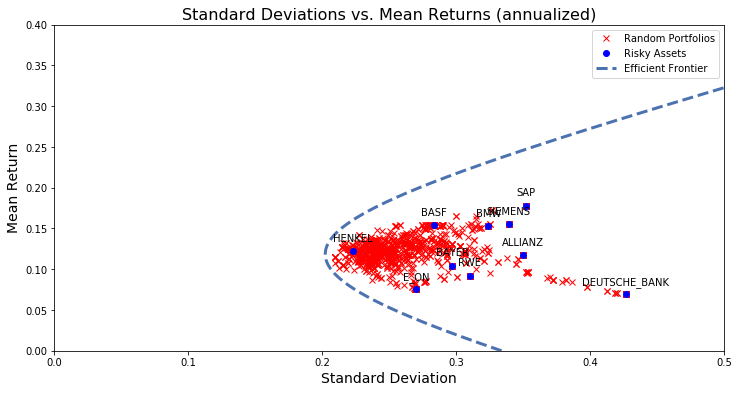

In [423]:
plt.figure(figsize = (12,6))
plt.plot(portfolio_std_returns['std'], portfolio_std_returns['return'], linestyle = "None", marker = 'x', color = 'red', label = 'Random Portfolios')
plt.plot(std_returns['std'], std_returns['return'], linestyle = "None", marker = 'o', color = 'blue', label = 'Risky Assets')
plt.plot(frontier_x, frontier_y, linestyle = '--', linewidth = 3, label = 'Efficient Frontier')
for i in range(0, len(std_returns)):
    index = std_returns.index.to_numpy()
    label = index[i]
    plt.annotate(label, (std_returns.iloc[i,1], std_returns.iloc[i,0]), textcoords = "offset points", xytext = (0, 10), ha = 'center')
plt.title('Standard Deviations vs. Mean Returns (annualized)', size = 16)
plt.xlabel('Standard Deviation', size = 14)
plt.ylabel('Mean Return', size = 14)
plt.xlim(0, 0.5)
plt.ylim(0, 0.4)
plt.legend()
plt.show()

## c)

In [424]:
min_var_portfolio = eff_portfolios[eff_portfolios['std'] == eff_portfolios['std'].min()]
print("\nMininum-Variance Portfolio:\n\n", min_var_portfolio)


Mininum-Variance Portfolio:

       w_DEUTSCHE_BANK  w_ALLIANZ    w_BASF  w_SIEMENS     w_BMW   w_BAYER  \
2964         0.202179   0.202333  0.202321   0.202169  0.201899  0.202381   

        w_E_ON     w_RWE  w_HENKEL     w_SAP       std    return  sharpe_ratio  
2964  0.202275  0.202444  0.202154  0.202232  0.202217  0.118572       0.58636  


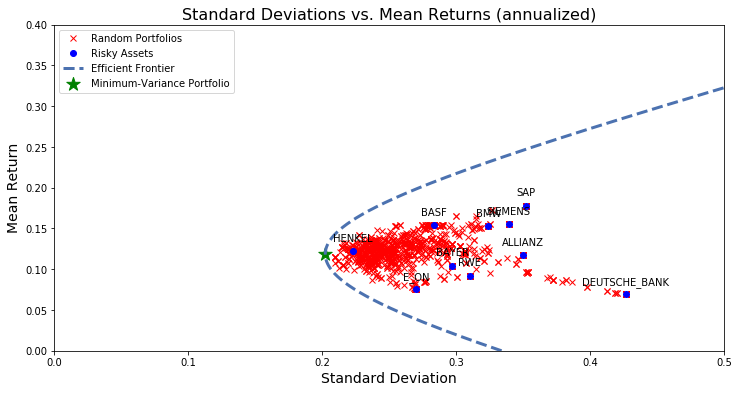

In [425]:
plt.figure(figsize = (12,6))
plt.plot(portfolio_std_returns['std'], portfolio_std_returns['return'], linestyle = "None", marker = 'x', color = 'red', label = 'Random Portfolios')
plt.plot(std_returns['std'], std_returns['return'], linestyle = "None", marker = 'o', color = 'blue', label = 'Risky Assets')
plt.plot(frontier_x, frontier_y, linestyle = '--', linewidth = 3, label = 'Efficient Frontier')
plt.scatter(min_var_portfolio['std'], min_var_portfolio['return'], color = 'green', marker = '*', s = 200, label = 'Minimum-Variance Portfolio')
for i in range(0, len(std_returns)):
    index = std_returns.index.to_numpy()
    label = index[i]
    plt.annotate(label, (std_returns.iloc[i,1], std_returns.iloc[i,0]), textcoords = "offset points", xytext = (0, 10), ha = 'center')
plt.title('Standard Deviations vs. Mean Returns (annualized)', size = 16)
plt.xlabel('Standard Deviation', size = 14)
plt.ylabel('Mean Return', size = 14)
plt.xlim(0, 0.5)
plt.ylim(0, 0.4)
plt.legend()
plt.show()

## d)

In [426]:
tan_portfolio = eff_portfolios[eff_portfolios['sharpe_ratio'] == eff_portfolios['sharpe_ratio'].max()]
print("\nTangency Portfolio:\n\n", min_var_portfolio)


Tangency Portfolio:

       w_DEUTSCHE_BANK  w_ALLIANZ    w_BASF  w_SIEMENS     w_BMW   w_BAYER  \
2964         0.202179   0.202333  0.202321   0.202169  0.201899  0.202381   

        w_E_ON     w_RWE  w_HENKEL     w_SAP       std    return  sharpe_ratio  
2964  0.202275  0.202444  0.202154  0.202232  0.202217  0.118572       0.58636  


In [427]:
a = (tan_portfolio['return'] - rf_return) / (tan_portfolio['std'] - 0)
b = rf_return - a * 0
tan_x = np.linspace(0, 1, 100)
tan_y = []
for x in tan_x:
    y = (a*x)+b
    tan_y.append(y)

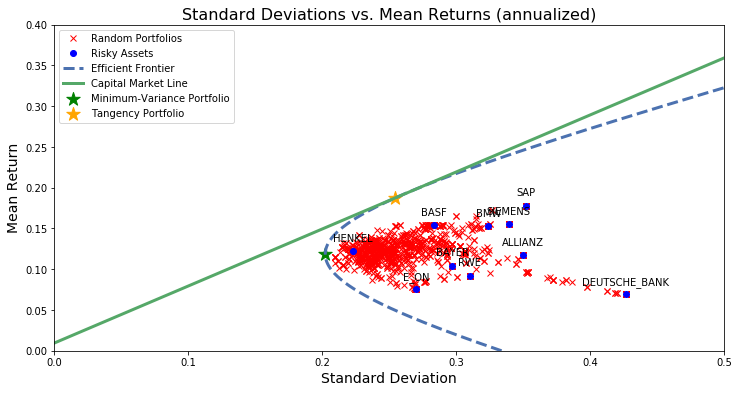

In [428]:
plt.figure(figsize = (12,6))
plt.plot(portfolio_std_returns['std'], portfolio_std_returns['return'], linestyle = "None", marker = 'x', color = 'red', label = 'Random Portfolios')
plt.plot(std_returns['std'], std_returns['return'], linestyle = "None", marker = 'o', color = 'blue', label = 'Risky Assets')
plt.plot(frontier_x, frontier_y, linestyle = '--', linewidth = 3, label = 'Efficient Frontier')
plt.scatter(min_var_portfolio['std'], min_var_portfolio['return'], color = 'green', marker = '*', s = 200, label = 'Minimum-Variance Portfolio')
plt.scatter(tan_portfolio['std'], tan_portfolio['return'], color = 'orange', marker = '*', s = 200, label = 'Tangency Portfolio')
plt.plot(tan_x, tan_y, linestyle = '-', linewidth = 3, label = 'Capital Market Line')
for i in range(0, len(std_returns)):
    index = std_returns.index.to_numpy()
    label = index[i]
    plt.annotate(label, (std_returns.iloc[i,1], std_returns.iloc[i,0]), textcoords = "offset points", xytext = (0, 10), ha = 'center')
plt.title('Standard Deviations vs. Mean Returns (annualized)', size = 16)
plt.xlabel('Standard Deviation', size = 14)
plt.ylabel('Mean Return', size = 14)
plt.xlim(0, 0.5)
plt.ylim(0, 0.4)
plt.legend()
plt.show()

## e)

In [429]:
k = 2
tan_return = tan_portfolio['return']

def get_utility(weights):
    weights = np.array(weights)
    utility = (weights[0] * tan_return) + rf_return - (0.5*k*(weights[0]**2)*tan_portfolio['std'])
    return utility

def check_sum(weights):
    return np.sum(weights)-1

def maximize_utility(weights):
    return -get_utility(weights)
    
init_guess = [1/2, 1/2]
cons = ({'type': 'eq', 'fun': check_sum})
result = minimize(maximize_utility, init_guess, method = 'SLSQP', constraints = cons)

# Results
print("\nOptimal allocation for portfolio in ETF and risk-free asset:\n")
print("Weight in ETF:", round(result['x'][0]*100, 2), "%")
print("Weight in risk-free asset: ", round(result['x'][1]*100, 2), "%")


Optimal allocation for portfolio in ETF and risk-free asset:

Weight in ETF: 36.84 %
Weight in risk-free asset:  63.16 %
